# Statistique en Grande Dimension et Apprentissage - TP 1


Ce TP est consacré aux k-plus proches voisins. A travers la mise en oeuvre de cet algorithme, les objectifs sont de se familiariser avec le calcul empirique du risque, la validation simple, la validation croisée ainsi que le choix de paramètres (ou hyper paramètres). On abordera aussi la notion de surapprentissage.



## Exercice 1

### 1. 

In [ ]:
def Echantillon(n):
    
    X1 = np.random.uniform(0,1,n)
    X2 = np.random.uniform(0,1,n)
    V = X1 + 2*X2
    Y = np.zeros(n)
    
    Y[V <= 1] = [int(alpha >= np.random.uniform(0,1,1)[0]) for i in range(np.sum(V <= 1))]
    Y[V > 1] = [int(beta >= np.random.uniform(0,1,1)[0]) for i in range(np.sum(V > 1))]
    
    return pd.DataFrame({'X1': X1,'X2': X2,'Y': Y.astype(int)})

### 2.

In [ ]:
from random import *
import numpy as np
import pandas as pd


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


n = 1000
max_Voisins = 100

alpha = 0.9
beta = 0.1

df_train = Echantillon(n)
df_test = Echantillon(n)

### 3.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(style="darkgrid")
# plt.figure(figsize=(8,8))
# sns.scatterplot(x="X1", y="X2", hue="Y", style = "Y", data=df_train, s =100)

In [ ]:
Xtrain,Ytrain = df_train[["X1","X2"]], df_train["Y"]
Xtest,Ytest = df_test[["X1","X2"]], df_test["Y"]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


Poids = ["uniform", "distance"]
p = Poids[0]

k = 1

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain, Ytrain) 

print(knn.predict([[0.5, 0.5]])," avec une probabilité de ", knn.predict_proba([[0.5, 0.5]]))
print(knn.predict([[1/4, 3/4]])," avec une probabilité de ", knn.predict_proba([[1/4, 3/4]]))

### 5.


In [ ]:
# Pour k = 1 :
knn = KNeighborsClassifier(n_neighbors=1, weights = p)
knn.fit(Xtrain, Ytrain)
k1 = knn.predict(Xtest)

# pour k = 20 :
knn = KNeighborsClassifier(n_neighbors=20, weights = p)
knn.fit(Xtrain, Ytrain)
k20 = knn.predict(Xtest)

#pd.DataFrame({"knn[K=1]": k1, "knn[K=20]": k20})

### 6. 

In [ ]:
from sklearn.metrics import confusion_matrix

print("matrice de confusion avec k=1")
M1 = confusion_matrix(Ytest, k1)
M1

In [ ]:
print("matrice de confusion avec k=20")
M20 = confusion_matrix(Ytest, k20)
M20

### 7.

In [ ]:
print("Précision de classification avec k=1:", M1.trace()/M1.sum())
print("Précision de classification avec k=20:", M20.trace()/M20.sum())

### 8.

In [ ]:
Voisins = np.arange(1,max_Voisins)
Precision_Uniform = []
Precision_Distance = []

for i in Voisins:
    knn = KNeighborsClassifier(n_neighbors=i, weights = "uniform")
    knn.fit(Xtrain, Ytrain)
    M = confusion_matrix(Ytest, knn.predict(Xtest))
    Precision_Uniform.append(M.trace()/M.sum())
    
for i in Voisins:
    knn = KNeighborsClassifier(n_neighbors=i, weights = "distance")
    knn.fit(Xtrain, Ytrain)
    M = confusion_matrix(Ytest, knn.predict(Xtest))
    Precision_Distance.append(M.trace()/M.sum())
    
df_Erreur_1 = pd.DataFrame({"Voisins": Voisins, 
                          "Précision": Precision_Uniform,
                          "Poids": "Uniforme"})

df_Erreur_2 = pd.DataFrame({"Voisins": Voisins, 
                          "Précision": Precision_Distance,
                          "Poids": "Distance"})
df_Erreur = pd.concat([df_Erreur_1, df_Erreur_2])

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", hue="Poids", data=df_Erreur)

### 9.

##### a. validation croisée de type Leave-One-Out

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

#on regroupe les données pour la validation croisée
df = pd.concat([df_train,df_test], ignore_index=True)
X, Y = df[["X1","X2"]], df["Y"]

loo = LeaveOneOut()
knn_cv = KNeighborsClassifier(n_neighbors=11, weights = p)
cv_scores = cross_val_score(knn_cv, X, Y, cv=loo)

print(cv_scores)
print("moyenne des scores:", np.mean(cv_scores))

##### b. programmant d'une validation croisée  avec 5-fold

In [ ]:
cv = 5
Voisins = np.arange(1,max_Voisins)

I=np.arange(df.shape[0])
taillefold = int(df.shape[0]/cv)

Cross_V = {}


for k in Voisins:  
    Precision = []

    for i in range(cv):
        
        Iv = I[i*taillefold: (i+1)*taillefold]
        
        Xtr=X.drop(Iv, axis=0)
        Ytr=Y.drop(Iv, axis=0)

        Xte=X.iloc[Iv]
        Yte=Y.iloc[Iv]
    
        knn = KNeighborsClassifier(n_neighbors=k, weights = p)
        knn.fit(Xtr, Ytr)
        M = confusion_matrix(Yte, knn.predict(Xte))
        Precision.append(M.trace()/M.sum())

    Cross_V [k] = round((np.array(Precision)).mean(), 4) 

In [ ]:
print("k:" ,max(zip(Cross_V.values(), Cross_V.keys()))[1])
print("précision:" ,max(zip(Cross_V.values(), Cross_V.keys()))[0])

In [ ]:
df_CV = pd.DataFrame({'Voisins'   : list(Cross_V.keys()),
                      'Précision' : list(Cross_V.values())})
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", data=df_CV)

In [ ]:
from sklearn.model_selection import GridSearchCV

#on crée un nouveau modèle knn2
knn2 = KNeighborsClassifier()

#on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
param_grid = {"n_neighbors": np.arange(1, max_Voisins), "weights" : ["uniform", "distance"]}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#ajustement du modèle aux données
knn_gscv.fit(X, Y)

In [ ]:
#la valeur de n_neighbors la plus performante:
knn_gscv.best_params_

In [ ]:
#le score moyen pour la valeur la plus performante de n_neighbors
knn_gscv.best_score_

# Exercice 2

### 1. 

In [ ]:
path_Home = "/home/malick/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"
path = "/users/mmath/wade/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"

df_train = pd.read_csv(path_Home + "/synth_train.txt",  sep='\t')
df_test = pd.read_csv(path_Home + "/synth_test.txt",  sep='\t')

In [ ]:
df_train.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lmplot(data=df_train, x='x1', y='x2', hue='y', markers=['o', 'o'], fit_reg=False)

### 2. 

In [ ]:
k = 30

Xtrain,Ytrain = df_train[["x1","x2"]], df_train["y"]
Xtest,Ytest = df_test[["x1","x2"]], df_test["y"]

##### 2.5 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain, Ytrain)
k30 = knn.predict(Xtest)

#pd.DataFrame({"knn[K=30]": k30})

##### 2.6

In [ ]:
print("matrice de confusion avec k=30")
M30 = confusion_matrix(Ytest, k30)
M30

##### 2.7

In [ ]:
print("Précision de classification avec k=30:", M30.trace()/M30.sum())


##### 2.9

###### a. validation croisée de type Leave-One-Out

In [ ]:
#on regroupe les données pour la validation croisée
df = pd.concat([df_train,df_test], ignore_index=True)
X, Y = df[["x1","x2"]], df["y"]

loo = LeaveOneOut()
knn_cv = KNeighborsClassifier(n_neighbors=k, weights = p)
cv_scores = cross_val_score(knn_cv, X, Y, cv=loo)

print(cv_scores)
print("moyenne des scores:", np.mean(cv_scores))

##### b. programmant d'une validation croisée  avec 5-fold

In [ ]:
cv = 5
max_Voisins = 50

Voisins = np.arange(1,max_Voisins)

I=np.arange(df.shape[0])
taillefold = int(df.shape[0]/cv)

Cross_V = {}


for k in Voisins:  
    Precision = []

    for i in range(cv):
        
        Iv = I[i*taillefold: (i+1)*taillefold]
        
        Xtr=X.drop(Iv, axis=0)
        Ytr=Y.drop(Iv, axis=0)

        Xte=X.iloc[Iv]
        Yte=Y.iloc[Iv]
    
        knn = KNeighborsClassifier(n_neighbors=k, weights = p)
        knn.fit(Xtr, Ytr)
        M = confusion_matrix(Yte, knn.predict(Xte))
        Precision.append(M.trace()/M.sum())

    Cross_V [k] = round((np.array(Precision)).mean(), 4) 

In [ ]:
print("k:" ,max(zip(Cross_V.values(), Cross_V.keys()))[1])
print("précision:" ,max(zip(Cross_V.values(), Cross_V.keys()))[0])

In [ ]:
df_CV = pd.DataFrame({'Voisins'   : list(Cross_V.keys()),
                      'Précision' : list(Cross_V.values())})
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Voisins", y="Précision", data=df_CV)

In [ ]:
from sklearn.model_selection import GridSearchCV

#on crée un nouveau modèle knn2
knn2 = KNeighborsClassifier()

#on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
param_grid = {"n_neighbors": np.arange(1, max_Voisins), "weights" : ["uniform", "distance"]}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#ajustement du modèle aux données
knn_gscv.fit(X, Y)

In [ ]:
#la valeur de n_neighbors la plus performante:
knn_gscv.best_params_

In [ ]:
#le score moyen pour la valeur la plus performante de n_neighbors
knn_gscv.best_score_

#### 3.

In [ ]:
# from matplotlib.colors import ListedColormap

# cmapColor = ListedColormap(['r', 'b'])

# # Method to create a mesh of points
# def makeMeshgrid(x, y, h=0.02):
#     x_min, x_max = x.min() - 1, x.max() + 1
#     y_min, y_max = y.min() - 1, y.max() + 1
#     # Meshgrid ndarrays
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
#     return xx, yy

# # Defining the data to use in meshgrid calculation. Outputting xx and yy ndarrays
# X0, X1 = X['x1'], X['x2']
# xx, yy = makeMeshgrid(X0, X1)

# for k in [30, 15, 1]:

#     # Training the model per the optimum k value
#     model = KNeighborsClassifier(n_neighbors=k, weights = p)
#     model.fit(X, Y)

#     # Calculating the decision boundaries
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     plt.figure(figsize=(9,9))


#     # Plotting the decision boundaries
#     plt.contourf(xx, yy, Z, alpha = 0.3, cmap=cmapColor)

#     # Scatter plot Sepal width/length
#     colorSet = {1:'r', 2:'b'}

#     plt.scatter(X0, X1,  marker='o', c=[colorSet[i] for i in df['y']], label=None)
#     plt.xlabel('x1')
#     plt.ylabel('x2')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

#     # Title
#     plt.title('Frontière de décision pour k=%.f'%(k))

#     # Legend
#     for name, color in zip(["1","2"], ['r', 'b']):
#             plt.scatter([], [], alpha=0.8, s=50, c=color, label=name)   

#     pst = plt.legend(loc='best', scatterpoints=1, frameon=True, fontsize='10',labelspacing=0.5, title='y')

# Exercice 3

### 1.

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
Poids = ["uniform", "distance"]
p = Poids[0]

In [2]:
path_Home = "/home/malick/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"
path = "/users/mmath/wade/Bureau/Data/Statistique_en_grande_dimension/Donnees_knn"

df_train = pd.read_csv(path_Home + "/mnist_train.csv",  sep=',')
df_test = pd.read_csv(path_Home + "/mnist_test.csv",  sep=',')

### 2.

In [3]:
Xtrain = df_train.iloc[:,1:df_train.shape[1]]
Ytrain = df_train.iloc[:,0:1]

Xtest = df_test.iloc[:,1:df_train.shape[1]]
Ytest = df_test.iloc[:,0:1]

### 3.

### 4. 

### 5.

In [4]:
import time

Xtrain_10 = Xtrain.iloc[0:10]
Ytrain_10 = Ytrain.iloc[0:10]

k = 5

t1 = time.time()

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain_10, Ytrain_10)

t2 = time.time()
t =t2 -t1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


### 6.

In [5]:
Xtrain_12000 = Xtrain.sample(n=12000, random_state=1, replace=False)
Xtrain_12000 = Xtrain_12000.reset_index(drop=True)

Ytrain_12000 = Ytrain.sample(n=12000, random_state=1, replace=False)
Ytrain_12000 = Ytrain_12000.reset_index(drop=True)

Xtest_500 = Xtest.sample(n=500, random_state=2, replace=False)
Xtest_500 = Xtest_500.reset_index(drop=True)

Ytest_500 = Ytest.sample(n=500, random_state=2, replace=False)
Ytest_500 = Ytest_500.reset_index(drop=True)

### 7.

In [6]:
k = 10

knn = KNeighborsClassifier(n_neighbors=k, weights = p)
knn.fit(Xtrain_12000, Ytrain_12000)

predict = knn.predict(Xtest_500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


### 8.

In [7]:
print("matrice de confusion")
M = confusion_matrix(Ytest_500, predict)
M

matrice de confusion


array([[55,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 51,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  3, 41,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0, 50,  0,  2,  0,  0,  1,  0],
       [ 1,  1,  0,  0, 47,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  2,  1, 41,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 40,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0,  0, 47,  0,  1],
       [ 0,  0,  2,  2,  0,  0,  0,  0, 48,  1],
       [ 0,  0,  0,  1,  1,  0,  0,  1,  0, 46]])

In [8]:
print("Précision de classification:", M.trace()/M.sum())

Précision de classification: 0.932


###### 9. Meilleur algorithme avec sklearn.model_selection.GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

# #on crée un nouveau modèle knn
# knn = KNeighborsClassifier()

# #on crée un dictionnaire de toutes les valeurs que nous voulons tester avec n_neighbors
# param_grid = {"n_neighbors": np.arange(1, 30), "weights" : ["uniform", "distance"]}

# #on utilise gridsearch pour tester toutes les valeurs de n_neighbors
# knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# #ajustement du modèle aux données
# knn_gscv.fit(Xtrain_12000 , Ytrain_12000 )

In [10]:
#la valeur de n_neighbors la plus performante:
# knn_gscv.best_params_

In [11]:
#le score moyen pour la valeur la plus performante de n_neighbors
# knn_gscv.best_score_

### Exercice 3 / TD2

### 2

#### a.

In [12]:
#classe pour l'ACP
from sklearn.decomposition import PCA

direction = 78

#instanciation
acp = PCA(n_components=direction)
acp.fit(Xtrain_12000)

#calculs
Xtrain_12000_ACP = acp.transform(Xtrain_12000)
Xtest_500_ACP = acp.transform(Xtest_500)

In [13]:
print("proportion total de variance associées aux axes: ",round(sum(acp.explained_variance_ratio_),4))

proportion total de variance associées aux axes:  0.8883


In [14]:
df1 = pd.DataFrame(Xtrain_12000_ACP[:,0:2]) # On garde les deux premiéres directions pour la représentation graphique
df_train_ACP = pd.concat([df1,Ytrain_12000], axis=1)
df_train_ACP.columns = ['X1', 'X2', 'chiffre']

df_train_ACP.head(10)

,X1,X2,chiffre
0,160.426664,509.292272,3
1,831.274853,638.712623,3
2,-404.279683,-281.302479,4
3,226.269777,-372.961890,5
4,-727.530473,138.551433,1
5,1034.786703,-162.724915,6
6,98.732793,115.297724,2
7,-180.485480,250.925081,2
8,-173.723115,699.732620,2
9,-0.147413,29.283739,2


In [15]:
print("proportion total de variance contenues dans les deux premiéres axes principales: ",round(sum(acp.explained_variance_ratio_[0:2]),4))

proportion total de variance contenues dans les deux premiéres axes principales:  0.1668


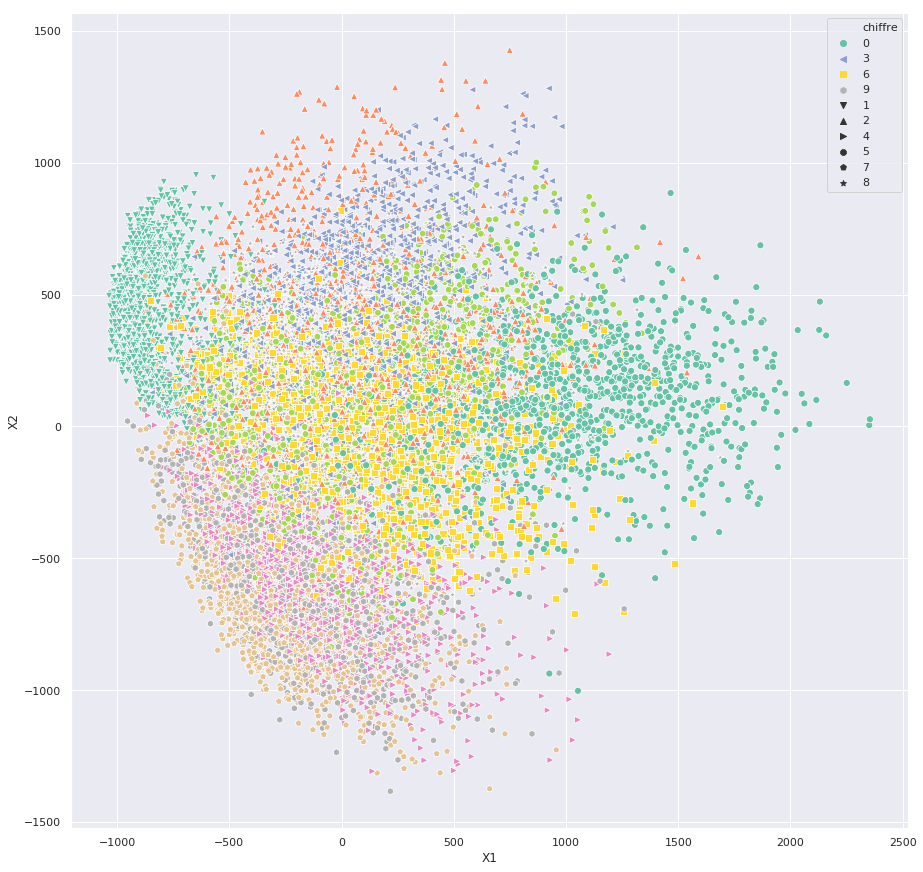

In [16]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,15))

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

sns.scatterplot(x="X1", y="X2", hue="chiffre", style="chiffre", palette="viridis", markers=filled_markers, data=df_train_ACP, s =50)

#### b. 

In [17]:
k = 10

knn_ACP = KNeighborsClassifier(n_neighbors=k, weights = p)
knn_ACP.fit(Xtrain_12000_ACP, Ytrain_12000)

predict_ACP = knn_ACP.predict(Xtest_500_ACP)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


In [18]:
print("matrice de confusion")
M_ACP = confusion_matrix(Ytest_500, predict_ACP)
M_ACP

matrice de confusion


array([[55,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 51,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  1, 43,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0, 50,  0,  2,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 47,  0,  2,  0,  0,  1],
       [ 0,  0,  0,  3,  1, 40,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 40,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0, 50,  0,  1],
       [ 0,  0,  1,  2,  0,  0,  0,  0, 49,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 48]])

In [19]:
print("Précision de classification avec une ACP de",direction,"composantes"," :", M_ACP.trace()/M_ACP.sum())

Précision de classification avec une ACP de 78 composantes  : 0.946


In [31]:
#On représente la précision en fonction du nombre de composantesdirectio

direction = 50
k = 10
Prec_Comp = {}

for d in np.arange(1,direction+1):
    print("\nIter:",d)
    
    #instanciation
    acp = PCA(n_components=d)
    acp.fit(Xtrain_12000)

    #calculs
    Xtrain_ACP = acp.transform(Xtrain_12000)
    Xtest_ACP = acp.transform(Xtest_500)

    knn_ACP = KNeighborsClassifier(n_neighbors=k, weights = p)
    knn_ACP.fit(Xtrain_ACP, Ytrain_12000)
    
    pred_ACP = knn_ACP.predict(Xtest_ACP)

    M = confusion_matrix(Ytest_500, pred_ACP)   
    Prec_Comp[d] = round(M.trace()/M.sum(), 4) 


Iter: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 34


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 35


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 36


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 37


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 38


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 39


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 40


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 41


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 42


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 43


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 44


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 45


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 46


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iter: 49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


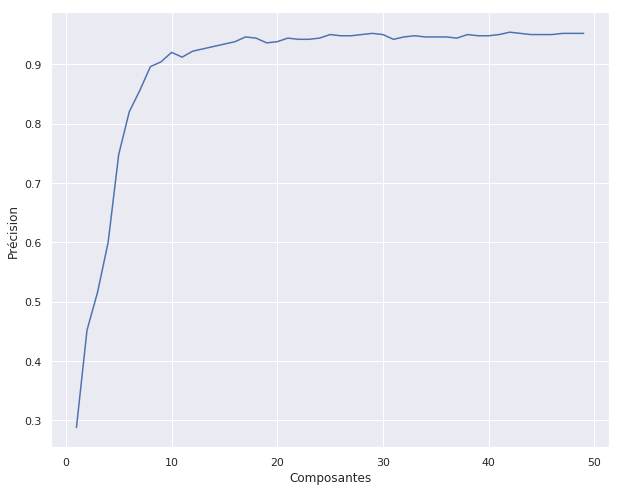

In [32]:
df_Prec_Comp = pd.DataFrame({'Composantes'   : list(Prec_Comp.keys()),
                      'Précision' : list(Prec_Comp.values())})
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.lineplot(x="Composantes", y="Précision", data=df_Prec_Comp)

#### c.  ACP à noyau

In [36]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=direction, kernel='rbf', gamma=10)
kpca.fit(Xtest_500)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=10, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=50, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

In [37]:
Xtest_500_kACP = kpca.transform(Xtest_500)

In [55]:
df1_kACP = pd.DataFrame(Xtest_500_kACP[:,0:2]) # On garde les deux premiéres directions pour la représentation graphique
df_train_kACP = pd.concat([df1_kACP,Ytest_500], axis=1)
df_train_kACP.columns = ['X1', 'X2', 'chiffre']

df_train_kACP[df_train_kACP.chiffre ==0].head(20)

,X1,X2,chiffre
7,-0.231467,0.0,9
8,0.238015,0.0,9
15,0.123672,0.0,9
19,0.013452,0.0,9
39,0.103945,0.0,9
42,-0.113936,0.0,9
53,-0.005894,0.0,9
54,-0.118588,0.0,9
71,-0.015203,0.0,9
83,-0.035247,0.0,9


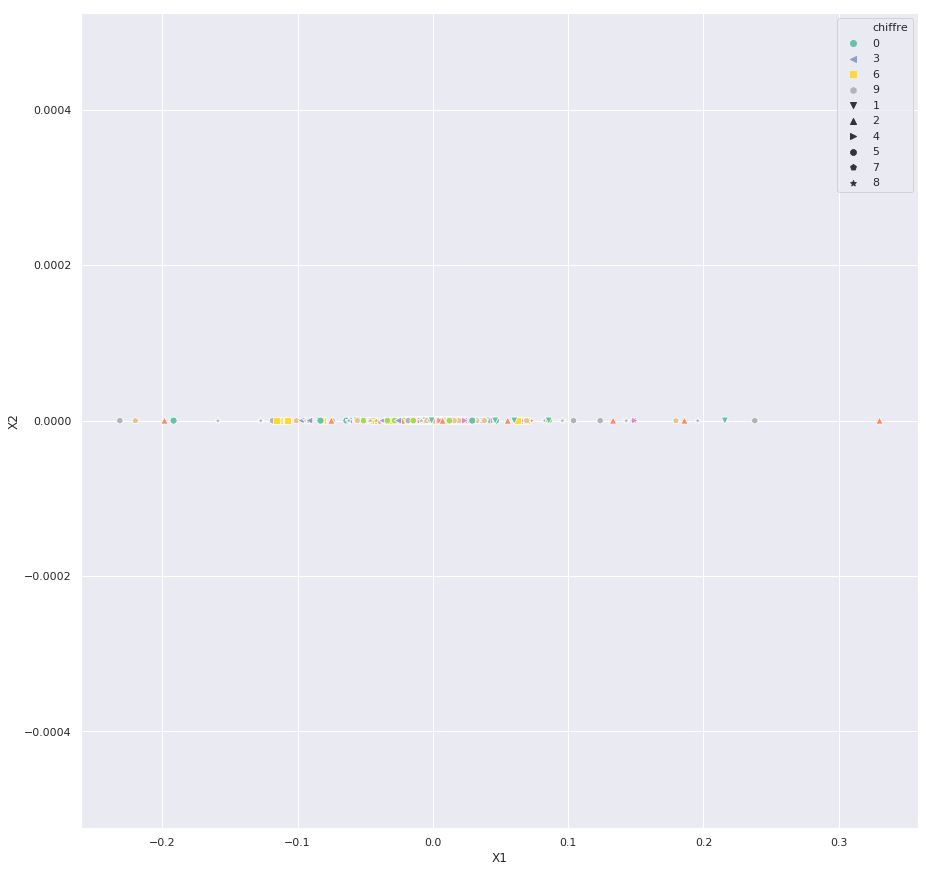

In [44]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,15))

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

sns.scatterplot(x="X1", y="X2", hue="chiffre", style="chiffre", palette="Set2", markers=filled_markers, data=df_train_kACP, s =50)